In [51]:
import sys
sys.path.append('generate_data')
from generator import *
import pandas as pd
import json

<h4>The task involves developing a data pipeline to complete the user story above using sample data
sources that will be provided.<br><br>
Our data science team has reached out to our data engineering team requesting we pre-process
some of the data for them at scale so that they can make better use of it in their downstream
algorithms.<br><br>
The input data sources are comprised of customers (in CSV format), transactions (in JSON Lines
format) and products (in CSV format). Their details are presented below</h4>

### Loading data

##### Customers

In [70]:
df_customers_loyalty = read_csv(os.path.join(output_location, 'customers.csv'))
df_customers_loyalty.head()

,customer_id,loyalty_score
0,C1,7
1,C2,4
2,C3,13
3,C4,11
4,C5,8


##### Products

In [48]:
df_products_category = read_csv(os.path.join(output_location, 'products.csv'))
df_products_category.head()

,product_id,product_description,product_category
0,P01,detergent,house
1,P02,kitchen roll,house
2,P03,bin liners,house
3,P04,shower gel,house
4,P05,scented candles,house


##### Transactions

In [55]:
df_transactions = read_json_folder(os.path.join(output_location, 'transactions',''))
df_transactions.head()

,customer_id,basket,date_of_purchase
0,C5,"[{'product_id': 'P56', 'price': 566}]",2023-01-29 11:07:42.437257
1,C7,"[{'product_id': 'P12', 'price': 1274}]",2023-01-28 21:25:42.437257
2,C8,"[{'product_id': 'P28', 'price': 494}, {'produc...",2023-01-29 05:34:42.437257
3,C10,"[{'product_id': 'P31', 'price': 17}, {'product...",2023-01-29 00:39:42.437257
4,C12,"[{'product_id': 'P11', 'price': 795}]",2023-01-29 01:35:42.437257


In [57]:
json_string = df_transactions.to_json(orient='records')

data_dict = json.loads(json_string)

df_customers_transactions = pd.json_normalize(data_dict, record_path='basket', meta=['customer_id', 'date_of_purchase'])
df_customers_transactions

,product_id,price,customer_id,date_of_purchase
0,P56,566,C5,2023-01-29 11:07:42.437257
1,P12,1274,C7,2023-01-28 21:25:42.437257
2,P28,494,C8,2023-01-29 05:34:42.437257
3,P28,16,C8,2023-01-29 05:34:42.437257
4,P31,17,C10,2023-01-29 00:39:42.437257
...,...,...,...,...
4303,P35,1770,C135,2023-04-28 18:40:42.437257
4304,P37,1110,C135,2023-04-28 18:40:42.437257
4305,P27,802,C137,2023-04-28 18:37:42.437257
4306,P34,1863,C137,2023-04-28 18:37:42.437257


In [58]:
customer_activity = pd.merge(df_products_category, df_customers_transactions, on='product_id', how='left')
customer_activity

,product_id,product_description,product_category,price,customer_id,date_of_purchase
0,P01,detergent,house,74,C23,2023-01-28 16:02:42.437257
1,P01,detergent,house,187,C67,2023-01-31 01:09:42.437257
2,P01,detergent,house,610,C22,2023-02-02 20:31:42.437257
3,P01,detergent,house,1873,C118,2023-02-04 06:29:42.437257
4,P01,detergent,house,612,C132,2023-02-03 15:55:42.437257
...,...,...,...,...,...,...
4303,P64,cigarettes,bws,275,C127,2023-04-24 06:39:42.437257
4304,P64,cigarettes,bws,127,C127,2023-04-24 06:39:42.437257
4305,P64,cigarettes,bws,1427,C15,2023-04-25 07:35:42.437257
4306,P64,cigarettes,bws,1985,C37,2023-04-26 02:37:42.437257


In [62]:
result_df = pd.merge(df_customers_loyalty, customer_activity, on='customer_id')
result_df

,customer_id,loyalty_score,product_id,product_description,product_category,price,date_of_purchase
0,C1,7,P42,chicken,food,1155,2023-02-10 09:19:42.437257
1,C1,7,P42,chicken,food,59,2023-02-14 18:36:42.437257
2,C1,7,P42,chicken,food,522,2023-03-09 04:33:42.437257
3,C1,7,P42,chicken,food,1117,2023-03-12 12:35:42.437257
4,C1,7,P44,milk,food,21,2023-02-10 09:19:42.437257
...,...,...,...,...,...,...,...
4303,C137,5,P33,apples,fruit_veg,684,2023-03-04 22:30:42.437257
4304,C137,5,P33,apples,fruit_veg,971,2023-03-23 16:35:42.437257
4305,C137,5,P34,raspberries,fruit_veg,1826,2023-03-03 08:07:42.437257
4306,C137,5,P34,raspberries,fruit_veg,1863,2023-04-28 18:37:42.437257


In [82]:
table_for_ds = result_df.groupby(['customer_id', 'loyalty_score', 'product_id', 'product_category']).size().reset_index(name='count')
table_for_ds

,customer_id,loyalty_score,product_id,product_category,count
0,C1,7,P42,food,4
1,C1,7,P44,food,1
2,C1,7,P45,food,1
3,C1,7,P47,food,1
4,C1,7,P48,food,3
...,...,...,...,...,...
2218,C99,8,P24,fruit_veg,1
2219,C99,8,P25,fruit_veg,2
2220,C99,8,P31,fruit_veg,1
2221,C99,8,P34,fruit_veg,1


### Task from Data Scientist

As a data scientist I want to be able to consume a data source that
contains information about how many times each of our customers
buys our products in a given period, so that I can predict what they
will buy next


The output data source should contain information for every customer that has the following
fields:

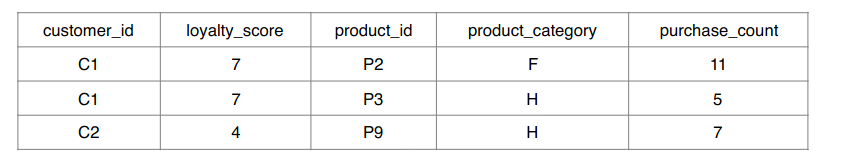